In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fitfit

In [5]:
def grid_data(uv,pixsize,npix):
    grid=np.zeros([npix,npix])
    mapsize=pixsize*npix
    dk=1.0/mapsize #this line sets absolute scaling - grid cell size in UV is
                   #1/mapsize in radians.  Vicki gets to grad student this up...
    uv_grid=np.asarray(np.round(uv/dk),dtype='int64') #convert uv floating points to grid cell coordinats
    nn=npix/2
    iscut=((np.abs(uv_grid[:,0])>nn)|(np.abs(uv_grid[:,1])>nn)) #chop out UV points that our map size/resolution won't fit
    if np.sum(iscut)>0:
        print('cutting '+np.sum(iscut)*100.0/uv.shape[0]+' percent of the data.  You may want to run with smaller pixels.')
        uv_grid=uv_grid[~iscut,:]
    uvgrid=np.append(uv_grid,-uv_grid,axis=0) #we have to reflect postive/negative UV so grid is symmetric
    ii=uvgrid[:,0]<0  #make sure all the negative coordinates go to positive, etc, so we can grid directly
    uvgrid[ii,0]=uvgrid[ii,0]+npix
    ii=uvgrid[:,1]<0
    uvgrid[ii,1]=uvgrid[ii,1]+npix

    for i in range(uvgrid.shape[0]):  #now loop over UV points and add them into the grid.                     
        #Vicki - you would put actual spectral fluxes here (instead of 1.0)
        grid[uvgrid[i,0],uvgrid[i,1]]=grid[uvgrid[i,0],uvgrid[i,1]]+1.0  
    return grid

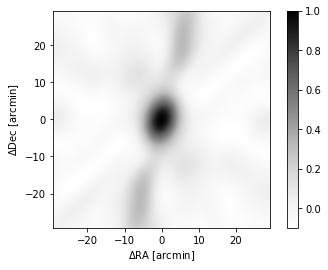

In [33]:
coords=pd.read_csv("/home/mohan/coords.csv")
xyz=np.zeros(coords.shape)
xyz[:,0] = np.cos(np.deg2rad(coords['lat']))*np.cos(np.deg2rad(coords['lon']))
xyz[:,1] = np.cos(np.deg2rad(coords['lat']))*np.sin(np.deg2rad(coords['lon']))
xyz[:,2] = np.sin(np.deg2rad(coords['lat']))
# xyz=np.zeros([latlon.shape[0],3])
# xyz[:,0]=np.cos(latlon[:,0])*np.cos(latlon[:,1])
# xyz[:,1]=np.cos(latlon[:,0])*np.sin(latlon[:,1])
# xyz[:,2]=np.sin(latlon[:,0])

xyz_cent=np.mean(xyz,axis=0)
nant=10

north=np.asarray([0,0,1.0])
north=north-np.dot(north,xyz_cent)*xyz_cent
north=north/np.sqrt(np.dot(north,north))
east=np.cross(north,xyz_cent)
dxyz=np.zeros([nant*(nant-1)//2,3])
ii=0
for i in range(nant):
    for j in range(i+1,nant):
        dxyz[ii,:]=xyz[i,:]-xyz[j,:]
        ii=ii+1

u=np.dot(dxyz,north)
v=np.dot(dxyz,east)
uv=np.zeros([len(u),2])
uv[:,0]=u
uv[:,1]=v
re=6.371e6
 
osamp=4
# pixsize_arcmin=0.5/osamp
pixsize_arcmin=0.2929
pixsize=pixsize_arcmin/60*np.pi/180

# nu=np.linspace(50,100,101)
nu=np.linspace(3.5,7,101)
lamda=300/nu
uu=np.outer(u,re/lamda)
vv=np.outer(v,re/lamda)

uu=np.reshape(uu,[uu.size,1])
vv=np.reshape(vv,[vv.size,1])
uv=np.append(uu,vv,axis=1)

#lamda=0.5
#uv=uv*re/lamda
# npix=1024*osamp
npix=2048
grid=grid_data(uv,pixsize,npix)
grid=grid/uv.shape[0]/2
beam=np.fft.fftshift(np.real(np.fft.fft2(grid)))

nn=100
stamp=beam[npix//2-nn:npix//2+nn,npix//2-nn:npix//2+nn]

#plt.ion()
plt.clf();
myext=np.asarray([-1,1,-1,1.0])*nn*pixsize_arcmin#*2*np.pi
plt.imshow(np.fliplr(stamp.T),extent=myext,cmap='Greys')
plt.xlabel('$\Delta$RA [arcmin]')
plt.ylabel('$\Delta$Dec [arcmin]')
plt.colorbar()

In [27]:
grid.shape

(2048, 2048)

FWHM along RA 4.43 arcmin
FWHM along dec 8.48 arcmin


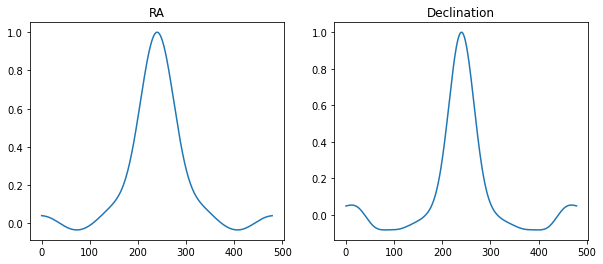

In [21]:
f=plt.gcf()
x0=stamp.shape[0]//2
f.set_size_inches(10,4)
xx=stamp[x0,:].copy()
xx=xx/xx.max()


plt.subplot(121)
plt.plot(xx)
plt.title("RA")
mygauss = lambda x,amp,mu,sig: amp*np.exp(-0.5*(x-mu)**2/sig**2)
fitp,cov=curve_fit(mygauss,np.arange(0,len(xx)),xx,[1,50,10])
print(f"FWHM along RA {np.rad2deg(fitp[2]*2.355*pixsize)*60:4.2f} arcmin")

xx=stamp[:,x0].copy()
xx=xx/xx.max()
plt.subplot(122)
plt.plot(xx)
plt.title("Declination")
mygauss = lambda x,amp,mu,sig: amp*np.exp(-0.5*(x-mu)**2/sig**2)
fitp,cov=curve_fit(mygauss,np.arange(0,len(xx)),xx,[1,50,10])
print(f"FWHM along dec {np.rad2deg(fitp[2]*2.355*pixsize)*60:4.2f} arcmin")